[View in Colaboratory](https://colab.research.google.com/github/IWichakam/smart-city/blob/master/DBSCAN.ipynb)

In [0]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

%matplotlib inline

# Read raw data

In [3]:
!wget https://github.com/IWichakam/smart-city/raw/master/CUBEM-1701010000-1703010000_sample.csv


Redirecting output to ‘wget-log’.


In [0]:
raw_fname = 'CUBEM-1701010000-1703010000_sample.csv'

In [5]:
!head {raw_fname} -n 3

"id";"time";"attrstring";"value"
"http://bems.ee.eng.chula.ac.th/ee/fl1/emu10x/sub14/phase_s/load15/monitor/energy";"2017-01-01 00:00:00+07";"";"0.017"
"http://bems.ee.eng.chula.ac.th/ee/fl1/corridor/elevator_front/z1/outlet1/monitor/energy";"2017-01-01 00:00:00+07";"";"1.051"


In [0]:
wholefile = pd.read_csv(raw_fname, low_memory=False, sep=';')

In [8]:
wholefile.head()

,id,time,attrstring,value
0,http://bems.ee.eng.chula.ac.th/ee/fl1/emu10x/s...,2017-01-01 00:00:00+07,NaN,0.017
1,http://bems.ee.eng.chula.ac.th/ee/fl1/corridor...,2017-01-01 00:00:00+07,NaN,1.051
2,http://bems.ee.eng.chula.ac.th/ee/fl2/west/sto...,2017-01-01 00:00:00+07,NaN,44.600
3,http://bems.ee.eng.chula.ac.th/ee/fl2/west/sto...,2017-01-01 00:00:59+07,NaN,44.600
4,http://bems.ee.eng.chula.ac.th/ee/fl1/emu10x/s...,2017-01-01 00:01:00+07,NaN,0.019


In [0]:
wholefile.drop('attrstring', axis=1, inplace=True)

In [10]:
wholefile.head()

,id,time,value
0,http://bems.ee.eng.chula.ac.th/ee/fl1/emu10x/s...,2017-01-01 00:00:00+07,0.017
1,http://bems.ee.eng.chula.ac.th/ee/fl1/corridor...,2017-01-01 00:00:00+07,1.051
2,http://bems.ee.eng.chula.ac.th/ee/fl2/west/sto...,2017-01-01 00:00:00+07,44.600
3,http://bems.ee.eng.chula.ac.th/ee/fl2/west/sto...,2017-01-01 00:00:59+07,44.600
4,http://bems.ee.eng.chula.ac.th/ee/fl1/emu10x/s...,2017-01-01 00:01:00+07,0.019


# Select one sensor

In [0]:
id_ = 'http://bems.ee.eng.chula.ac.th/ee/fl1/corridor/elevator_front/z1/outlet1/monitor/energy'

In [0]:
df = wholefile[wholefile.id == id_].reset_index(drop=True)
df['value'] = pd.to_numeric(df['value'])
df['time'] = pd.to_datetime(df['time'])

series = df.set_index('time').value.sort_index()

In [13]:
series.head()

time
2016-12-31 17:00:00    1.051
2016-12-31 17:01:00    1.809
2016-12-31 17:02:00    1.830
2016-12-31 17:03:00    1.834
2016-12-31 17:04:00    1.832
Name: value, dtype: float64

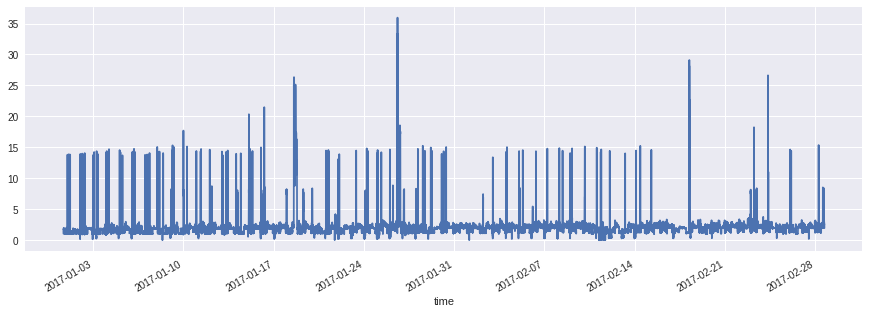

In [14]:
series.plot(figsize=(15, 5))

# Aggregate by hour

In [0]:
index_hour = series.index.to_series().dt.floor(freq='H')
series = series.groupby(index_hour).sum()

In [16]:
series.head()

time
2016-12-31 17:00:00    90.541
2016-12-31 18:00:00    67.321
2016-12-31 19:00:00    66.532
2016-12-31 20:00:00    68.264
2016-12-31 21:00:00    83.638
Name: value, dtype: float64

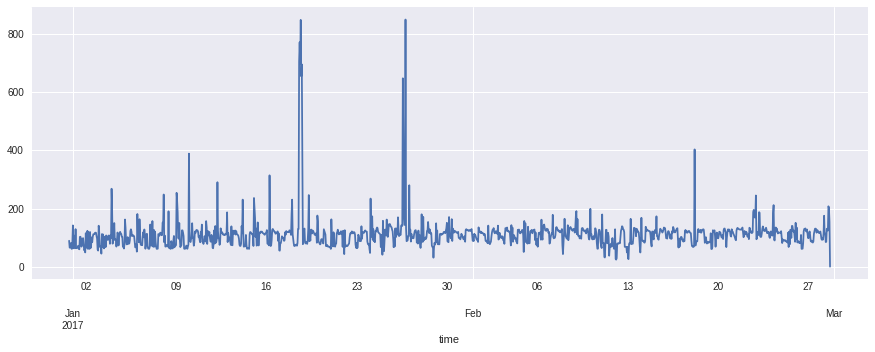

In [17]:
series.plot(figsize=(15, 5))

# Add missing timestamp

In [0]:
datetime_index = pd.DatetimeIndex(start=series.index.min(), end=series.index.max(), freq='H').rename('time')
series = series.reindex(datetime_index)

# Detect outliers with DBSCAN

In [0]:
def get_outliers(series, eps, min_samples, y_space=1):
    """
    series : data (pandas.Series)
    eps : maximum distance of points in the same cluster (numeric)
    min_samples : the minimum number of points to be considered a cluster (integer)
    """
    X = series.tolist()
    y = np.arange(0, series.shape[0]*change_per_timestep, change_per_timestep)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(list(zip(X, y)))
    result = [i for i in range(len(dbscan.labels_)) if dbscan.labels_[i] < 0]
    return series.iloc[result].index

## Calculate changes allowed between timesteps

In [0]:
diff = (series - series.shift(1)).abs()
change_per_timestep = diff.mean() + 2*diff.std()

eps = change_per_timestep * 2**0.5

## Run

In [0]:
outliers = get_outliers(series=series, eps=eps, min_samples=3, y_space=change_per_timestep)

# Visualize

In [0]:
def plot_outliers(series, outliers, figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    series.plot(ax=ax, color='b')
    series.loc[outliers].plot(style='.', color='r')

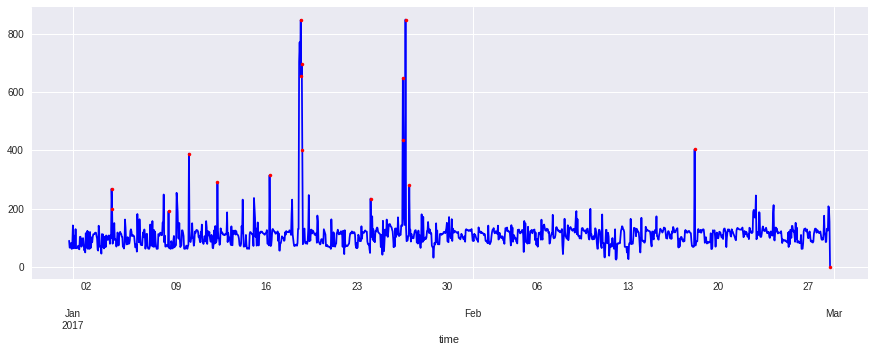

In [23]:
plot_outliers(series, outliers)